In [1]:
import numpy as np
import os
import pandas as pd
import scipy.interpolate
import sklearn.metrics
import sys
sys.path.append("../src")
import localmodule

from matplotlib import pyplot as plt
%matplotlib inline


# Define constants.
dataset_name = localmodule.get_dataset_name()
models_dir = localmodule.get_models_dir()
units = localmodule.get_units()
n_units = len(units)
n_thresholds = 221
n_trials = 10
n_eval_trials = 5


# Initialize dictionary.
reports = {}

model_names = [
    "icassp-convnet",
    "icassp-ntt-convnet",
    "icassp-add-convnet",
    "pcen-convnet",
    "pcen-ntt-convnet",
    "pcen-add-convnet"]


# Loop over models.
for model_name in model_names:
    
    # Initialize dictionary.
    report = {}

    # Loop over augmentations.
    for aug_kind_str in ["none", "all-but-noise", "all"]:

        
        # Initialize dictionaries.
        aug_report = {
            "validation": {},
            "test-CV-F": {},
        }


        # Initialize precisions, recalls, and F1 scores.
        val_precisions = np.zeros((n_units, n_trials))
        val_recalls = np.zeros((n_units, n_trials))
        val_f1_scores = np.zeros((n_units, n_trials))
        val_thresholds = np.zeros((n_units, n_trials))
        val_threshold_ids = np.zeros((n_units, n_trials))
        val_auprcs = np.zeros((n_units, n_trials))

        
        # Define thresholds.
        thresholds = 1.0 - np.concatenate((
            np.logspace(-9, -2, 141), np.delete(np.logspace(-2, 0, 81), 0)
        ))
        n_thresholds = len(thresholds)


        # Define model directory.
        if not aug_kind_str == "none":
            aug_model_name = "_".join([model_name, "aug-" + aug_kind_str])
        else:
            aug_model_name = model_name
        model_dir = os.path.join(models_dir, aug_model_name)


        # Loop over test units.
        for test_unit_id in range(n_units):

            # Define directory for test unit.
            test_unit_str = units[test_unit_id]
            test_unit_dir = os.path.join(model_dir, test_unit_str)

            # Retrieve fold such that unit_str is in the test set.
            folds = localmodule.fold_units()
            fold = [f for f in folds if test_unit_str in f[0]][0]
            test_units = fold[0]
            validation_units = fold[2]

            # Loop over trials.
            for trial_id in range(n_trials):

                trial_str = "trial-" + str(trial_id)
                trial_dir = os.path.join(test_unit_dir, trial_str)
                break_switch = False

                # Loop over validation units.
                for predict_unit_str in validation_units:
                    val_metrics_name = "_".join([
                        dataset_name,
                        aug_model_name,
                        "test-" + test_unit_str,
                        trial_str,
                        "predict-" + predict_unit_str,
                        "full-audio-metrics.csv"
                    ])
                    val_metrics_path = os.path.join(trial_dir, val_metrics_name)
                    val_tp = np.zeros((n_thresholds,))
                    val_fp = np.zeros((n_thresholds,))
                    val_fn = np.zeros((n_thresholds,))
                    try:
                        val_metrics_df = pd.read_csv(val_metrics_path)
                        val_tp = val_tp + np.array(val_metrics_df["True positives"])
                        val_fp = val_fp + np.array(val_metrics_df["False positives"])
                        val_fn = val_fn + np.array(val_metrics_df["False negatives"])
                    except:
                        break_switch = True
                        break

                if break_switch:
                    val_auprc = 0.0
                    val_p = np.zeros((n_thresholds,))
                    val_r = np.zeros((n_thresholds,))
                    val_f = np.zeros((n_thresholds,))
                    val_threshold_id = 0
                else:
                    val_p = val_tp / (np.finfo(float).eps + val_tp + val_fp)
                    val_r = val_tp / (np.finfo(float).eps + val_tp + val_fn)
                    val_f = 2*val_p*val_r / (np.finfo(float).eps+(val_p+val_r))
                    val_threshold_id = np.argmax(val_f)
                    val_p_ = np.array([1.0] + list(val_p) + [0.0])
                    val_r_ = np.array([0.0] + list(val_r) + [1.0])
                    val_auprc = sklearn.metrics.auc(val_r_, val_p_, reorder=True)

                val_precisions[test_unit_id, trial_id] = val_p[val_threshold_id]
                val_recalls[test_unit_id, trial_id] = val_r[val_threshold_id]
                val_f1_scores[test_unit_id, trial_id] = val_f[val_threshold_id]
                val_thresholds[test_unit_id, trial_id] = thresholds[val_threshold_id]
                val_threshold_ids[test_unit_id, trial_id] = val_threshold_id
                val_auprcs[test_unit_id, trial_id] = val_auprc


        aug_report["validation"]["P"] = val_precisions
        aug_report["validation"]["R"] = val_recalls
        aug_report["validation"]["F"] = val_f1_scores
        aug_report["validation"]["AUPRC"] = val_auprcs
        aug_report["validation"]["threshold"] = val_thresholds
        aug_report["validation"]["threshold_ids"] = val_threshold_ids
        aug_report["validation"]["trials_F"] = np.argsort(val_f1_scores, axis=1)
        aug_report["validation"]["trials_AUPRC"] = np.argsort(val_auprcs, axis=1)


        # Initialize precisions, recalls, and F1 scores.
        F_trials = aug_report["validation"]["trials_F"]
        test_precisions = np.zeros((n_units, n_trials))
        test_recalls = np.zeros((n_units, n_trials))
        test_f1_scores = np.zeros((n_units, n_trials))
        test_bools = np.ones((n_units, n_trials), dtype=bool)

        
        # Loop over test units.
        for test_unit_id in range(n_units):
            test_unit_str = units[test_unit_id]
            test_unit_dir = os.path.join(model_dir, test_unit_str)
        
            # Loop over trials.
            for eval_trial_id in range(n_trials):
                trial_id = F_trials[test_unit_id, eval_trial_id]
                trial_str = "trial-" + str(trial_id)
                trial_dir = os.path.join(test_unit_dir, trial_str)

                # Load test predictions.
                test_metrics_name = "_".join([
                    dataset_name,
                    aug_model_name,
                    "test-" + test_unit_str,
                    trial_str,
                    "predict-" + test_unit_str,
                    "full-audio-metrics.csv"
                ])
                test_metrics_path = os.path.join(trial_dir, test_metrics_name)
                
                threshold_id = int(val_threshold_ids[test_unit_id, trial_id])
        
                try:
                    test_metrics_df = pd.read_csv(test_metrics_path)
                    test_tp = np.array(test_metrics_df["True positives"])
                    test_tp = test_tp[threshold_id]
                    test_fp = np.array(test_metrics_df["False positives"])
                    test_fp = test_fp[threshold_id]
                    test_fn = np.array(test_metrics_df["False negatives"])
                    test_fn = test_fn[threshold_id]
                    
                    test_p = test_tp / (test_tp+test_fp)
                    test_r = test_tp /(test_tp+test_fn)
                    test_f1_score = (2*test_p*test_r) / (test_p+test_r)
                    
                    test_precisions[test_unit_id, trial_id] = test_p
                    test_recalls[test_unit_id, trial_id] = test_r
                    test_f1_scores[test_unit_id, trial_id] = test_f1_score
                    
                except:
                    test_bools[test_unit_id, trial_id] = False
          
        
        aug_report["test-CV-F"]["P"] = test_precisions
        aug_report["test-CV-F"]["R"] = test_recalls
        aug_report["test-CV-F"]["F"] = test_f1_scores 
        aug_report["test-CV-F"]["is_valid"] = test_bools
        
        report[aug_kind_str] = aug_report
    
    reports[model_name] = report

/home/vl1019/miniconda3/lib/python3.6/site-packages/ipykernel/__main__.py:194: RuntimeWarning: invalid value encountered in long_scalars


In [20]:
np.mean(np.nanmax(reports["icassp-convnet"]["all"]["validation"]["F"], axis=1))

0.67623526122556443

In [21]:
np.mean(np.nanmax(reports["pcen-convnet"]["all"]["test-CV-F"]["F"], axis=1))

0.66434634242849144

In [131]:
# PCEN CONVNET (none) BY UNITS
aug_kind_str = "none"
model_name = "pcen-convnet"
if not aug_kind_str == "none":
    model_name = "_".join([model_name, "aug-" + aug_kind_str])
model_dir = os.path.join(models_dir, model_name)
test_fs = []

for test_unit_id in range(n_units):
    test_unit_str = units[test_unit_id]
    test_unit_dir = os.path.join(model_dir, test_unit_str)
    trial_id = [3, 1, 6, 1, 4, 6][test_unit_id]
    trial_str = "trial-" + str(trial_id)
    trial_dir = os.path.join(test_unit_dir, trial_str)

    # Load test predictions.
    test_metrics_name = "_".join([
        dataset_name,
        model_name,
        "test-" + test_unit_str,
        trial_str,
        "predict-" + test_unit_str,
        "full-audio-metrics.csv"
    ])
    test_metrics_path = os.path.join(trial_dir, test_metrics_name)
    test_metrics_df = pd.read_csv(test_metrics_path)
    test_tp = np.array(test_metrics_df["True positives"])
    test_fp = np.array(test_metrics_df["False positives"])
    test_fn = np.array(test_metrics_df["False negatives"])
    
    test_p = test_tp / (np.finfo(float).eps + test_tp + test_fp)
    test_r = test_tp / (np.finfo(float).eps + test_tp + test_fn)
    test_f = 2*test_p*test_r / (np.finfo(float).eps+test_p+test_r)
    
    test_fs.append(test_f)
    
plt.plot(np.array(test_fs).T);


print(" ".join(["{:5.2f}".format(100 * np.max(np.array(test_fs), axis=1)[i]) for i in range(6)]))
print("Fixed th: {:5.2f}%".format(100 * np.max(np.mean(np.array(test_fs), axis=0))))
print("Oracle th: {:5.2f}%".format(100 * np.mean(np.max(np.array(test_fs), axis=1))))

EmptyDataError: No columns to parse from file

67.15 59.88 68.61 50.64 76.93 75.65
Fixed th: 61.63%
Oracle th: 66.48%


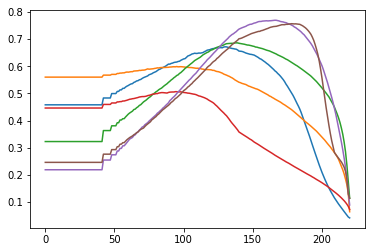

In [28]:
# PCEN CONVNET (all) BY UNITS
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import os
import sys

sys.path.append("../src")
import localmodule

dataset_name = localmodule.get_dataset_name()
models_dir = localmodule.get_models_dir()
units = localmodule.get_units()
n_units = len(units)
models_dir = localmodule.get_models_dir()

aug_kind_str = "all"
model_name = "pcen-convnet"
if not aug_kind_str == "none":
    model_name = "_".join([model_name, "aug-" + aug_kind_str])
model_dir = os.path.join(models_dir, model_name)
test_fs = []

for test_unit_id in range(n_units):
    test_unit_str = units[test_unit_id]
    test_unit_dir = os.path.join(model_dir, test_unit_str)
    trial_id = [0, 3, 5, 2, 1, 1][test_unit_id]
    trial_str = "trial-" + str(trial_id)
    trial_dir = os.path.join(test_unit_dir, trial_str)

    # Load test predictions.
    test_metrics_name = "_".join([
        dataset_name,
        model_name,
        "test-" + test_unit_str,
        trial_str,
        "predict-" + test_unit_str,
        "full-audio-metrics.csv"
    ])
    test_metrics_path = os.path.join(trial_dir, test_metrics_name)
    test_metrics_df = pd.read_csv(test_metrics_path)
    test_tp = np.array(test_metrics_df["True positives"])
    test_fp = np.array(test_metrics_df["False positives"])
    test_fn = np.array(test_metrics_df["False negatives"])
    
    test_p = test_tp / (np.finfo(float).eps + test_tp + test_fp)
    test_r = test_tp / (np.finfo(float).eps + test_tp + test_fn)
    test_f = 2*test_p*test_r / (np.finfo(float).eps+test_p+test_r)
    
    test_fs.append(test_f)
 

%matplotlib inline
plt.plot(np.array(test_fs).T);


print(" ".join(["{:5.2f}".format(100 * np.max(np.array(test_fs), axis=1)[i]) for i in range(6)]))
print("Fixed th: {:5.2f}%".format(100 * np.max(np.mean(np.array(test_fs), axis=0))))
print("Oracle th: {:5.2f}%".format(100 * np.mean(np.max(np.array(test_fs), axis=1))))

In [128]:
prediction_name = 'BirdVox-70k_icassp-ntt-convnet_aug-all-but-noise_test-unit01_trial-2_predict-unit01_full-predictions.csv'
prediction_path = os.path.join('/scratch/vl1019/BirdVox-70k_models/icassp-ntt-convnet_aug-all-but-noise/unit01/trial-2', prediction_name)
prediction_df = pd.read_csv(prediction_path)
odf = np.array(prediction_df["Predicted probability"])
timestamps = np.array(prediction_df["Timestamp"])

data_dir = localmodule.get_data_dir()
annotations_name = "_".join([dataset_name, "annotations"])
annotations_dir = os.path.join(data_dir, annotations_name)
annotation_path = os.path.join(annotations_dir, predict_unit_str + ".txt")
annotation = pd.read_csv(annotation_path, "\t")
begin_times = np.array(annotation["Begin Time (s)"])
end_times = np.array(annotation["End Time (s)"])
relevant = 0.5 * (begin_times + end_times)
relevant = np.sort(relevant)
n_relevant = len(relevant)

In [129]:
import peakutils
import mir_eval
min_dist = 3
tolerance = 0.500

for threshold in np.linspace(0.0, 1.0):
    # Pick peaks.
    peak_locations = peakutils.indexes(
        odf, thres=threshold, min_dist=min_dist)
    peak_times = timestamps[peak_locations]
    peak_values = odf[peak_locations]
    selected = peak_times[peak_values > threshold]

    # Match events.
    selected_relevant = mir_eval.util.match_events(
        relevant, selected, tolerance)

    # Count TP, FP, and FN.
    true_positives = len(selected_relevant)
    n_selected = len(selected)
    false_positives = n_selected - true_positives
    false_negatives = n_relevant - true_positives

    # Compute precision, recall, and F1 score.
    if n_selected == 0 or true_positives == 0:
        precision = 0.0
        recall = 0.0
        f1_score = 0.0
    else:
        precision = 100 * true_positives / n_selected
        recall = 100 * true_positives / n_relevant
        f1_score = 2*precision*recall / (precision+recall)

    print(threshold, precision, recall, f1_score)

0.0 10.81576535288726 6.7236467236467234 8.292340126493324
0.0204081632653 10.81576535288726 6.7236467236467234 8.292340126493324
0.0408163265306 10.81576535288726 6.7236467236467234 8.292340126493324
0.0612244897959 10.81576535288726 6.7236467236467234 8.292340126493324
0.0816326530612 10.81576535288726 6.7236467236467234 8.292340126493324
0.102040816327 10.81576535288726 6.7236467236467234 8.292340126493324
0.122448979592 10.81576535288726 6.7236467236467234 8.292340126493324
0.142857142857 10.81576535288726 6.7236467236467234 8.292340126493324
0.163265306122 10.81576535288726 6.7236467236467234 8.292340126493324
0.183673469388 10.81576535288726 6.7236467236467234 8.292340126493324
0.204081632653 10.81576535288726 6.7236467236467234 8.292340126493324
0.224489795918 10.81576535288726 6.7236467236467234 8.292340126493324
0.244897959184 10.81576535288726 6.7236467236467234 8.292340126493324
0.265306122449 10.81576535288726 6.7236467236467234 8.292340126493324
0.285714285714 10.815765352

In [122]:
peak_values

array([ 0.42482075,  0.47879133,  0.49174303, ...,  0.40501526,
        0.64083487,  0.90799558])

In [130]:
# NTT CONVNET (all but noise) BY UNITS
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import os
import sys

sys.path.append("../src")
import localmodule

dataset_name = localmodule.get_dataset_name()
models_dir = localmodule.get_models_dir()
units = localmodule.get_units()
n_units = len(units)
models_dir = localmodule.get_models_dir()

aug_kind_str = "all-but-noise"
model_name = "icassp-ntt-convnet"
if not aug_kind_str == "none":
    model_name = "_".join([model_name, "aug-" + aug_kind_str])
model_dir = os.path.join(models_dir, model_name)
test_fs = []

for test_unit_id in range(n_units):
    test_unit_str = units[test_unit_id]
    test_unit_dir = os.path.join(model_dir, test_unit_str)
    trial_id = [2, 4, 1, 2, 0, 0][test_unit_id]
    trial_str = "trial-" + str(trial_id)
    trial_dir = os.path.join(test_unit_dir, trial_str)

    # Load test predictions.
    test_metrics_name = "_".join([
        dataset_name,
        model_name,
        "test-" + test_unit_str,
        trial_str,
        "predict-" + test_unit_str,
        "full-audio-metrics.csv"
    ])
    test_metrics_path = os.path.join(trial_dir, test_metrics_name)
    test_metrics_df = pd.read_csv(test_metrics_path)
    test_tp = np.array(test_metrics_df["True positives"])
    test_fp = np.array(test_metrics_df["False positives"])
    test_fn = np.array(test_metrics_df["False negatives"])
    
    test_p = test_tp / (np.finfo(float).eps + test_tp + test_fp)
    test_r = test_tp / (np.finfo(float).eps + test_tp + test_fn)
    test_f = 2*test_p*test_r / (np.finfo(float).eps+test_p+test_r)
    
    test_fs.append(test_f)
 

%matplotlib inline
#plt.plot(np.array(test_fs).T);


print(" ".join(["{:5.2f}".format(100 * np.max(np.array(test_fs), axis=1)[i]) for i in range(6)]))
print("Fixed th: {:5.2f}%".format(100 * np.max(np.mean(np.array(test_fs), axis=0))))
print("Oracle th: {:5.2f}%".format(100 * np.mean(np.max(np.array(test_fs), axis=1))))

31.17 51.96 70.35 52.40 79.03 66.65
Fixed th: 49.98%
Oracle th: 58.59%


In [152]:
# NTT CONVNET (all but noise) BY UNITS
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import os
import sys

sys.path.append("../src")
import localmodule

dataset_name = localmodule.get_dataset_name()
models_dir = localmodule.get_models_dir()
units = localmodule.get_units()
n_units = len(units)
models_dir = localmodule.get_models_dir()

aug_kind_str = "all"
model_name = "icassp-convnet"
if not aug_kind_str == "none":
    model_name = "_".join([model_name, "aug-" + aug_kind_str])
model_dir = os.path.join(models_dir, model_name)
test_fs = []

for test_unit_id in range(n_units):
    test_unit_str = units[test_unit_id]
    test_unit_dir = os.path.join(model_dir, test_unit_str)
    trial_id = [0, 7, 2, 1, 0, 0][test_unit_id]
    trial_str = "trial-" + str(trial_id)
    trial_dir = os.path.join(test_unit_dir, trial_str)

    # Load test predictions.
    test_metrics_name = "_".join([
        dataset_name,
        model_name,
        "test-" + test_unit_str,
        trial_str,
        "predict-" + test_unit_str,
        "full-audio-metrics.csv"
    ])
    test_metrics_path = os.path.join(trial_dir, test_metrics_name)
    test_metrics_df = pd.read_csv(test_metrics_path)
    test_tp = np.array(test_metrics_df["True positives"])
    test_fp = np.array(test_metrics_df["False positives"])
    test_fn = np.array(test_metrics_df["False negatives"])
    
    test_p = test_tp / (np.finfo(float).eps + test_tp + test_fp)
    test_r = test_tp / (np.finfo(float).eps + test_tp + test_fn)
    test_f = 2*test_p*test_r / (np.finfo(float).eps+test_p+test_r)
    
    test_fs.append(test_f)
 

%matplotlib inline
#plt.plot(np.array(test_fs).T);


print(" ".join(["{:5.2f}".format(100 * np.max(np.array(test_fs), axis=1)[i]) for i in range(6)]))
print("Fixed th: {:5.2f}%".format(100 * np.max(np.mean(np.array(test_fs), axis=0))))
print("Oracle th: {:5.2f}%".format(100 * np.mean(np.max(np.array(test_fs), axis=1))))

45.08 63.89 70.71 48.28 66.55 74.59
Fixed th: 59.69%
Oracle th: 61.52%


In [91]:
test_unit_id = 0
test_unit_str = units[test_unit_id]
test_unit_dir = os.path.join(model_dir, test_unit_str)
trial_id = [5, 8, 1, 2, 0, 0][test_unit_id]
trial_str = "trial-" + str(trial_id)
trial_dir = os.path.join(test_unit_dir, trial_str)

# Load test predictions.
test_metrics_name = "_".join([
    dataset_name,
    model_name,
    "test-" + test_unit_str,
    trial_str,
    "predict-" + test_unit_str,
    "full-audio-metrics.csv"
])
test_metrics_path = os.path.join(trial_dir, test_metrics_name)
test_metrics_df = pd.read_csv(test_metrics_path)
test_tp = np.array(test_metrics_df["True positives"])
test_fp = np.array(test_metrics_df["False positives"])
test_fn = np.array(test_metrics_df["False negatives"])

test_p = test_tp / (np.finfo(float).eps + test_tp + test_fp)
test_r = test_tp / (np.finfo(float).eps + test_tp + test_fn)
test_f = 2*test_p*test_r / (np.finfo(float).eps+test_p+test_r)

test_metrics_path

'/scratch/vl1019/BirdVox-70k_models/icassp-ntt-convnet_aug-all-but-noise/unit01/trial-5/BirdVox-70k_icassp-ntt-convnet_aug-all-but-noise_test-unit01_trial-5_predict-unit01_full-audio-metrics.csv'

In [85]:
test_unit_id = 0
test_unit_str = units[test_unit_id]
test_unit_dir = os.path.join(model_dir, test_unit_str)
trial_id = [2, 8, 1, 2, 0, 0][test_unit_id]
trial_str = "trial-" + str(trial_id)
trial_dir = os.path.join(test_unit_dir, trial_str)

# Load test predictions.
test_metrics_name = "_".join([
    dataset_name,
    model_name,
    "test-" + test_unit_str,
    trial_str,
    "predict-" + test_unit_str,
    "full-audio-metrics.csv"
])
test_metrics_path = os.path.join(trial_dir, test_metrics_name)
test_metrics_df = pd.read_csv(test_metrics_path)
test_tp = np.array(test_metrics_df["True positives"])
test_fp = np.array(test_metrics_df["False positives"])
test_fn = np.array(test_metrics_df["False negatives"])

test_p = test_tp / (np.finfo(float).eps + test_tp + test_fp)
test_r = test_tp / (np.finfo(float).eps + test_tp + test_fn)
test_f = 2*test_p*test_r / (np.finfo(float).eps+test_p+test_r)

test_metrics_name

'BirdVox-70k_icassp-ntt-convnet_aug-all-but-noise_test-unit01_trial-2_predict-unit01_full-audio-metrics.csv'

In [134]:
# ICASSP CONVNET

import numpy as np
import os
import pandas as pd
import scipy.interpolate
import sklearn.metrics
import sys
sys.path.append("../src")
import localmodule


from matplotlib import pyplot as plt
%matplotlib inline

# Define constants.
dataset_name = localmodule.get_dataset_name()
models_dir = localmodule.get_models_dir()
units = localmodule.get_units()
n_units = len(units)
n_thresholds = 221
n_trials = 10
n_eval_trials = 5


# Initialize dicts.
report = {}


# Loop over augmentations.
for aug_kind_str in ["none", "all"]:

    # Define thresholds
    thresholds = 1.0 - np.concatenate((
        np.logspace(-9, -2, 141), np.delete(np.logspace(-2, 0, 81), 0)
    ))
    n_thresholds = len(thresholds)


    # Define model directory
    model_name = "pcen-convnet"
    if not aug_kind_str == "none":
        model_name = "_".join([model_name, "aug-" + aug_kind_str])
    model_dir = os.path.join(models_dir, model_name)


    # Loop over test units.
    for test_unit_id in range(n_units):

        test_unit_str = units[test_unit_id]
        test_unit_dir = os.path.join(model_dir, test_unit_str)

        # Retrieve fold such that unit_str is in the test set.
        folds = localmodule.fold_units()
        fold = [f for f in folds if test_unit_str in f[0]][0]
        test_units = fold[0]
        validation_units = fold[2]


        val_losses = []
        for trial_id in range(n_trials):
            trial_str = "trial-" + str(trial_id)
            trial_dir = os.path.join(test_unit_dir, trial_str)
            history_name = "_".join([
                dataset_name,
                model_name,
                test_unit_str,
                trial_str,
                "history.csv"
            ])
            history_path = os.path.join(
                trial_dir, history_name)
            try:
                history_df = pd.read_csv(history_path)
                val_loss = min(history_df["Validation loss"])
            except:
                val_loss = np.inf
            val_losses.append(val_loss)

        val_losses = np.array(val_losses)
        best_trial_id = np.argmin(val_losses)
        best_trial_str = "trial-" + str(best_trial_id)
        trial_dir = os.path.join(test_unit_dir, best_trial_str)

        # Load test predictions.
        test_metrics_name = "_".join([
            dataset_name,
            model_name,
            "test-" + test_unit_str,
            best_trial_str,
            "predict-" + test_unit_str,
            "full-audio-metrics.csv"
        ])
        test_metrics_path = os.path.join(trial_dir, test_metrics_name)
        test_metrics_df = pd.read_csv(test_metrics_path)
        test_tp = test_tp + np.array(test_metrics_df["True positives"])
        test_fp = test_fp + np.array(test_metrics_df["False positives"])
        test_fn = test_fn + np.array(test_metrics_df["False negatives"])

        test_p = test_tp / (np.finfo(float).eps + test_tp + test_fp)
        test_r = test_tp / (np.finfo(float).eps + test_tp + test_fn)
        test_p_ = np.array([1.0] + list(test_p) + [0.0])
        test_r_ = np.array([0.0] + list(test_r) + [1.0])
        test_auprc = sklearn.metrics.auc(test_r_, test_p_, reorder=True)

array([ 0.84209762,  0.84209762,  0.84209762,  0.84209762,  0.84209762,
        0.84209762,  0.84209762,  0.84209762,  0.84209762,  0.84209762,
        0.84209762,  0.84209762,  0.84209762,  0.84209762,  0.84209762,
        0.84209762,  0.84209762,  0.84209762,  0.84209762,  0.84209762,
        0.84209762,  0.84209762,  0.84209762,  0.84209762,  0.84209762,
        0.84209762,  0.84209762,  0.84209762,  0.84209762,  0.84209762,
        0.84209762,  0.84209762,  0.84209762,  0.84209762,  0.84209762,
        0.84209762,  0.84209762,  0.84209762,  0.84209762,  0.84209762,
        0.84209762,  0.84209762,  0.83514083,  0.83514083,  0.83514083,
        0.83514083,  0.83514083,  0.83514083,  0.83077349,  0.83077349,
        0.83077349,  0.83077349,  0.82920556,  0.82920556,  0.82717925,
        0.82717925,  0.82548982,  0.82548982,  0.82403625,  0.82325471,
        0.82218707,  0.82096667,  0.81986449,  0.8186322 ,  0.81686653,
        0.81598958,  0.81413904,  0.81254922,  0.81038129,  0.80